# Augmentasi DCGAN

# **3x lipat ke 360 gambar**


In [ ]:
import os
import zipfile
import random
import shutil

In [ ]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Unzipping the dataset
zip_path = '/content/drive/MyDrive/rice_leaf_diseases.zip'
extract_path = '/content/rice_leaf_diseases'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
os.listdir(extract_path)

Mounted at /content/drive


['Leaf smut', 'Brown spot', 'Bacterial leaf blight']

In [ ]:
# Unzipping the dataset
zip_path = '/content/drive/MyDrive/3x_360.zip'
extract_path = '/content/augmented_images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
os.listdir(extract_path)

['Leaf smut', 'Brown spot', 'Bacterial leaf blight']

Hitung Jumlah Gambar yang Di augmentasi

In [ ]:
def count_images_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        # Hanya menghitung file dengan ekstensi gambar
        count += len([file for file in files if file.lower().endswith(('.jpg', '.jpeg'))])
    return count

# Daftar nama kelas
classes = ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

# Path direktori augmented images
augmented_dir = '/content/augmented_images'

# Hitung gambar yang telah di augmentasi dalam setiap kelas
for cls in classes:
    augmented_class_dir = os.path.join(augmented_dir, cls)
    count = count_images_in_directory(augmented_class_dir)
    print(f"Number of images in {cls}: {count}")


Number of images in Bacterial leaf blight: 120
Number of images in Brown spot: 120
Number of images in Leaf smut: 120


Fungsi untuk Memisahkan Data dengan Pengacakan Data Asli

In [ ]:
import os
import shutil
import numpy as np

def split_data(source_dir, augmented_dir, train_dir, val_dir, test_dir, val_size_per_class, test_size_per_class, train_aug_size, train_orig_size):
    classes = os.listdir(source_dir)
    for cls in classes:
        cls_source = os.path.join(source_dir, cls)
        cls_augmented = os.path.join(augmented_dir, cls)
        cls_train = os.path.join(train_dir, cls)
        cls_val = os.path.join(val_dir, cls)
        cls_test = os.path.join(test_dir, cls)

        os.makedirs(cls_train, exist_ok=True)
        os.makedirs(cls_val, exist_ok=True)
        os.makedirs(cls_test, exist_ok=True)

        # Get and shuffle original image files
        image_files = [f for f in os.listdir(cls_source) if f.endswith('.jpg') or f.endswith('.JPG')]
        np.random.shuffle(image_files)

        # Check if there are enough images for validation and test
        total_needed = val_size_per_class + test_size_per_class
        if len(image_files) < total_needed + train_orig_size:
            raise ValueError(f"Not enough images in class {cls} to split into required parts")

        # Split data into validation and test sets
        val_files = image_files[:val_size_per_class]
        test_files = image_files[val_size_per_class:val_size_per_class + test_size_per_class]
        train_orig_files = image_files[val_size_per_class + test_size_per_class:val_size_per_class + test_size_per_class + train_orig_size]

        for file in val_files:
            src_path = os.path.join(cls_source, file)
            dst_path = os.path.join(cls_val, file)
            shutil.copyfile(src_path, dst_path)

        for file in test_files:
            src_path = os.path.join(cls_source, file)
            dst_path = os.path.join(cls_test, file)
            shutil.copyfile(src_path, dst_path)

        for file in train_orig_files:
            src_path = os.path.join(cls_source, file)
            dst_path = os.path.join(cls_train, file)
            shutil.copyfile(src_path, dst_path)

        # Handle training from augmented data
        aug_image_files = [f for f in os.listdir(cls_augmented) if f.endswith('.jpg') or f.endswith('.JPG')]
        np.random.shuffle(aug_image_files)
        train_aug_files = aug_image_files[:train_aug_size]

        for file in train_aug_files:
            src_path = os.path.join(cls_augmented, file)
            dst_path = os.path.join(cls_train, file)
            shutil.copyfile(src_path, dst_path)

Definisi Direktori dan Eksekusi Fungsi

In [ ]:
# Define directories
source_dir = '/content/rice_leaf_diseases'  # original images
augmented_dir = '/content/augmented_images'  # augmented images
train_dir = '/content/split_dataset/train'
val_dir = '/content/split_dataset/val'
test_dir = '/content/split_dataset/test'

# Define sizes for split per class
val_size_per_class = 10
test_size_per_class = 10
train_aug_size = 120
train_orig_size = 20

# Perform split
split_data(source_dir, augmented_dir, train_dir, val_dir, test_dir, val_size_per_class, test_size_per_class, train_aug_size, train_orig_size)

Fungsi untuk Menghitung Jumlah Gambar dalam Setiap Direktori

In [ ]:
def count_images_in_directory(directory):
    class_counts = {}
    for cls in os.listdir(directory):
        cls_dir = os.path.join(directory, cls)
        class_counts[cls] = len(os.listdir(cls_dir))
    return class_counts

Verifikasi Pemisahan Data

In [ ]:
print("Training set:")
print(count_images_in_directory(train_dir))
print("\nValidation set:")
print(count_images_in_directory(val_dir))
print("\nTest set:")
print(count_images_in_directory(test_dir))

Training set:
{'Leaf smut': 140, 'Brown spot': 140, 'Bacterial leaf blight': 140}

Validation set:
{'Leaf smut': 10, 'Brown spot': 10, 'Bacterial leaf blight': 10}

Test set:
{'Leaf smut': 10, 'Brown spot': 10, 'Bacterial leaf blight': 10}


Load Dataset

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=4)
}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Coba

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy
from torchsummary import summary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(image_datasets['train'].classes))

model = model.to(device)
summary(model, (3, 224, 224))  # Display model summary

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            history[phase + '_loss'].append(epoch_loss)
            history[phase + '_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, history

model, history = train_model(model, criterion, optimizer, dataloaders, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 49.1MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

In [ ]:
# Evaluate model and print classification report
from sklearn.metrics import classification_report # Import the missing module

def evaluate_model(model, dataloaders):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=image_datasets['train'].classes))

evaluate_model(model, dataloaders)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Classification Report:
                       precision    recall  f1-score   support

Bacterial leaf blight       0.91      1.00      0.95        10
           Brown spot       1.00      0.90      0.95        10
            Leaf smut       0.90      0.90      0.90        10

             accuracy                           0.93        30
            macro avg       0.94      0.93      0.93        30
         weighted avg       0.94      0.93      0.93        30



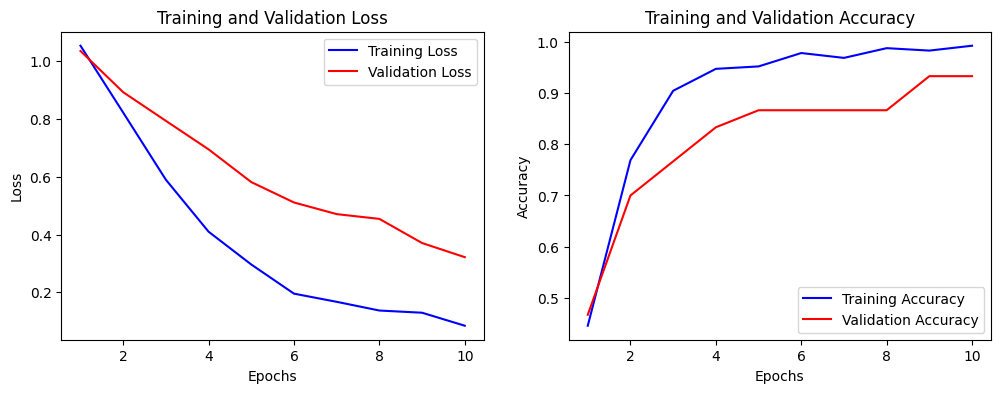

In [ ]:
import matplotlib.pyplot as plt

# Plotting loss and accuracy
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

In [ ]:
model.eval()
running_corrects = 0
all_preds = []
all_labels = []

for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

test_acc = running_corrects.double() / len(dataloaders['test'].dataset)
print(f'Test Acc: {test_acc:.4f}')

# Save the model
torch.save(model.state_dict(), 'best_model.pth')

# Load the model
model.load_state_dict(torch.load('best_model.pth'))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Acc: 0.9333


<All keys matched successfully>

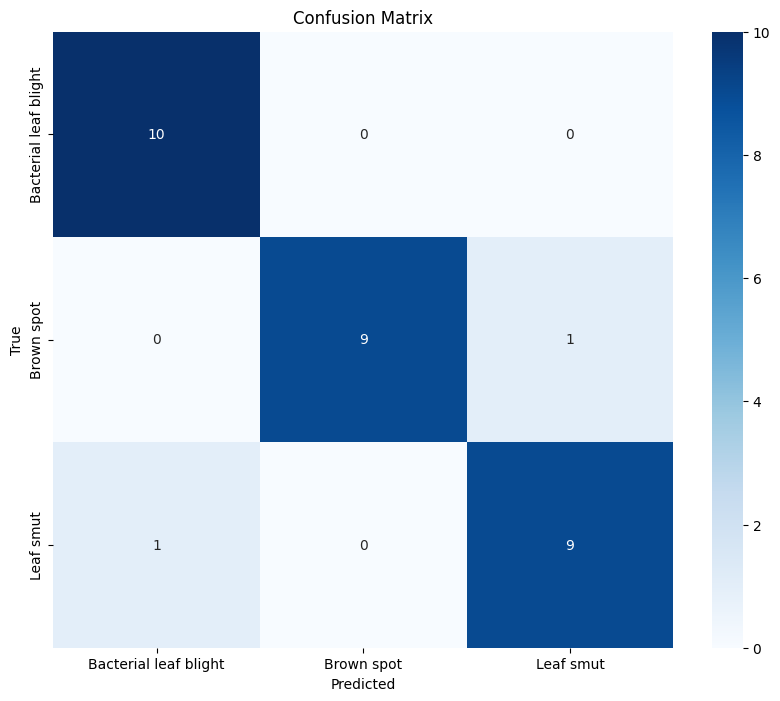

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
cm_labels = image_datasets['test'].classes

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Saving DSC_0372.JPG to DSC_0372.JPG
Predicted class for DSC_0372.JPG: Bacterial leaf blight


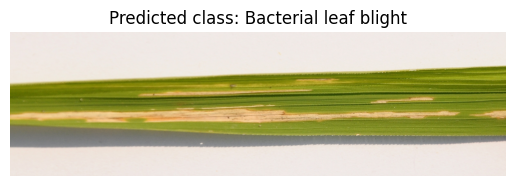

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
import os

# Definisikan ulang arsitektur model yang sama tanpa auxiliary layers
model = models.googlenet(pretrained=False, aux_logits=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(image_datasets['train'].classes))

# Muat model yang telah dilatih
state_dict = torch.load('best_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()  # Set model ke evaluasi mode

# Definisikan transformasi
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Fungsi untuk memproses gambar baru
def process_image(image_path):
    image = Image.open(image_path)
    image = data_transforms(image)
    image = image.unsqueeze(0)  # Tambahkan batch dimension
    return image

# Unggah gambar
uploaded = files.upload()

# Pindahkan model ke device yang sesuai (CPU atau GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Lakukan prediksi dan tampilkan gambar
for filename in uploaded.keys():
    image_tensor = process_image(filename)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        _, preds = torch.max(outputs, 1)

    # Dapatkan kelas prediksi
    predicted_class = image_datasets['train'].classes[preds.item()]
    print(f'Predicted class for {filename}: {predicted_class}')

    # Tampilkan gambar
    image = Image.open(filename)
    plt.imshow(image)
    plt.title(f'Predicted class: {predicted_class}')
    plt.axis('off')
    plt.show()